In [1]:
import os
import pandas as pd
import joblib
import backtrader as bt
import ml_investing_wne.config as config

In [2]:
start_date = joblib.load(os.path.join(config.package_directory, 'models',
                                      'first_sequence_ends_{}_{}_{}.save'.format('test',
                                                                                 config.currency,
                                                                                 config.freq)))
end_date = joblib.load(os.path.join(config.package_directory, 'models',
                                    'last_sequence_ends_{}_{}_{}.save'.format('test',
                                                                              config.currency,
                                                                              config.freq)))

In [3]:
df = pd.read_csv(os.path.join(config.processed_data_path, config.currency,
                               'Backtest_{}_{}.csv'.format(config.freq, config.model)), parse_dates=['datetime'])

In [4]:
df.head(3)

,datetime,open,high,low,close,y_pred,change,prediction_1
0,2022-01-20 00:00:00,1.03910,1.03950,1.03719,1.03795,0,-0.001079,0.462630
1,2022-01-20 12:00:00,1.03796,1.03863,1.03635,1.03683,0,-0.002083,0.474599
2,2022-01-21 00:00:00,1.03683,1.03690,1.03346,1.03467,0,-0.000445,0.396620


In [5]:
df.set_index('datetime', inplace=True)

In [6]:
df.head(3)

,open,high,low,close,y_pred,change,prediction_1
datetime,,,,,,,
2022-01-20 00:00:00,1.03910,1.03950,1.03719,1.03795,0,-0.001079,0.462630
2022-01-20 12:00:00,1.03796,1.03863,1.03635,1.03683,0,-0.002083,0.474599
2022-01-21 00:00:00,1.03683,1.03690,1.03346,1.03467,0,-0.000445,0.396620


In [7]:
df.dtypes

open            float64
high            float64
low             float64
close           float64
y_pred            int64
change          float64
prediction_1    float64
dtype: object

In [8]:
# class to define the columns we will provide
class MyData(bt.feeds.PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = ['open', 'high', 'low', 'close', 'volume', 'prediction_1']
# create lines
    lines = tuple(cols)
# define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [9]:
data = MyData(dataname=df)

In [10]:
data

In [11]:
class ModelInvesting(bt.Strategy):
    params = (
    ('lower_bound', 0.5),
    ('upper_bound', 0.5)
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        # params is abbreviated to p
        self.lower_bound = self.p.lower_bound
        self.upper_bound = self.p.upper_bound
        self.data_predicted = self.datas[0].prediction_1
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
        
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
     
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
    
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.size))
    
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
    
            self.bar_executed = len(self)
    
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
    
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.4f, NET %.4f' %
                 (trade.pnl, trade.pnlcomm))
    
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.4f, predicted value: %.4f' % (self.data_close[0], self.data_predicted[0] ))

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            
            size = int(self.broker.getcash() / self.data_close[0])
            # Not yet ... we MIGHT BUY if ...
            if self.data_predicted[0] > self.upper_bound:

                # BUY, BUY, BUY!!! (with default parameters)
                self.log('BUY CREATE, %.4f' % self.data_close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=size)
                
            elif self.data_predicted[0] < self.lower_bound:
                self.log('SHORT SELL CREATE, %.4f' % self.data_close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(size=size)

        else:

            # Already in the market with short position
            if self.position.size<0 and self.data_predicted[0] > self.lower_bound:
    
                # cover short
                self.log('COVER SHORT, %.4f' % self.data_close[0])
                self.order = self.buy(size=-self.position.size)
                # go long if possible
                if self.data_predicted[0] > self.upper_bound:
                    self.log('BUY CREATE, %.4f' % self.data_close[0])
                    size = int(self.broker.getcash() / self.data_close[0])
                    self.order = self.buy(size=size)
                    
            # Already in the market with long position
            if self.position.size>0 and self.data_predicted[0] < self.upper_bound:
    
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.4f' % self.data_close[0])
                self.order = self.sell(size=self.position.size)
                # go short if possible
                if self.data_predicted[0] < self.lower_bound:
                    size = int(self.broker.getcash() / self.data_close[0])
                    self.log('SHORT SELL CREATE, %.4f' % self.data_close[0])
                    self.order = self.sell(size=size)
                          


In [12]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(ModelInvesting, lower_bound=0.4, upper_bound=0.6)
cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.0002)

In [13]:
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2022-01-20, Close, 1.0379, predicted value: 0.4626
2022-01-20, Close, 1.0368, predicted value: 0.4746
2022-01-21, Close, 1.0347, predicted value: 0.3966
2022-01-21, SHORT SELL CREATE, 1.0347
2022-01-21, SELL EXECUTED, Price: 1.03, Cost: -99999.82, Comm 20.00
2022-01-21, Close, 1.0342, predicted value: 0.5848
2022-01-21, COVER SHORT, 1.0342
2022-01-23, BUY EXECUTED, Price: 1.03, Cost: -99999.82, Comm 19.98, Size 96649.00
2022-01-23, OPERATION PROFIT, GROSS 113.0793, NET 73.1020
2022-01-23, Close, 1.0352, predicted value: 0.4809
2022-01-24, Close, 1.0343, predicted value: 0.5036
2022-01-24, Close, 1.0354, predicted value: 0.4887
2022-01-25, Close, 1.0374, predicted value: 0.5140
2022-01-25, Close, 1.0371, predicted value: 0.4727
2022-01-26, Close, 1.0392, predicted value: 0.5310
2022-01-26, Close, 1.0374, predicted value: 0.4703
2022-01-27, Close, 1.0382, predicted value: 0.4889
2022-01-27, Close, 1.0374, predicted value: 0.4795
2022-01-28, Close, 1.03

In [28]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

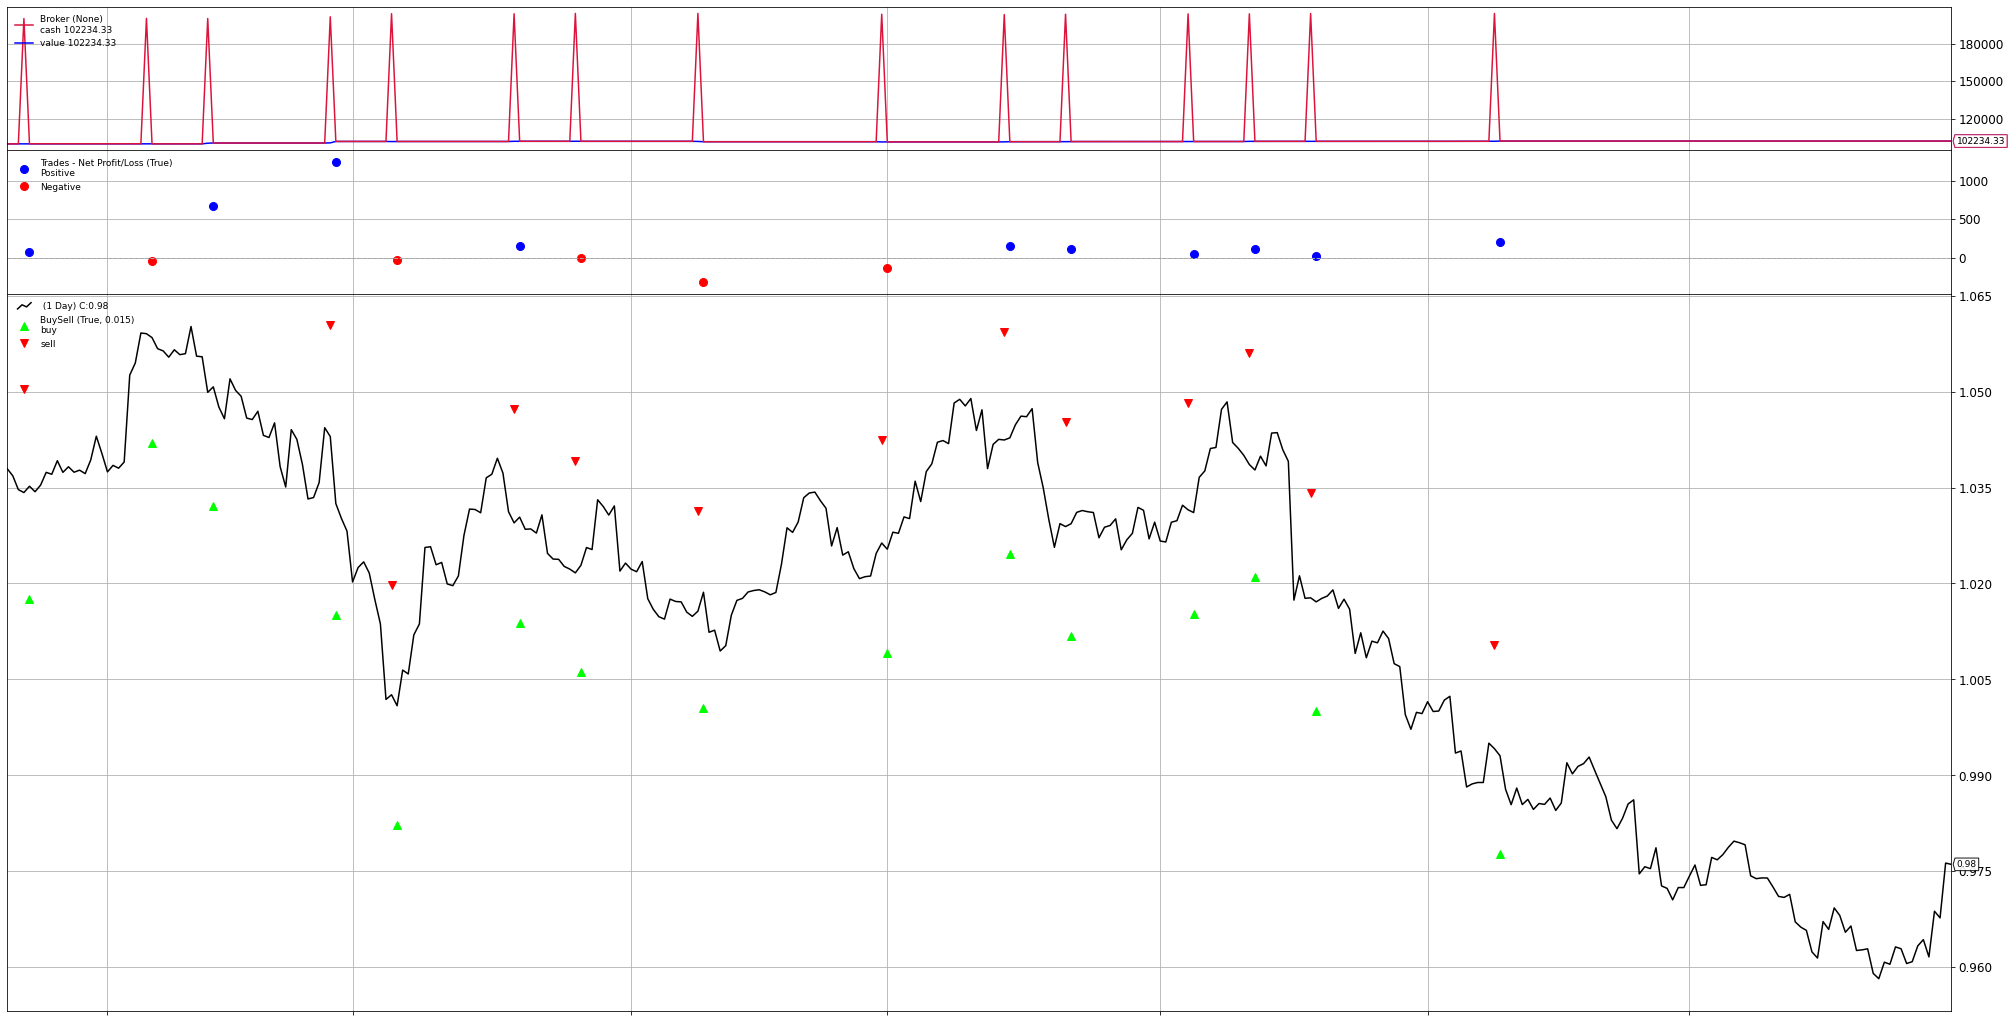

[[<Figure size 2160x1080 with 3 Axes>]]

In [36]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams.update({'font.size': 12})
cerebro.plot(volume=False, iplot = False, figsize=(60,60))

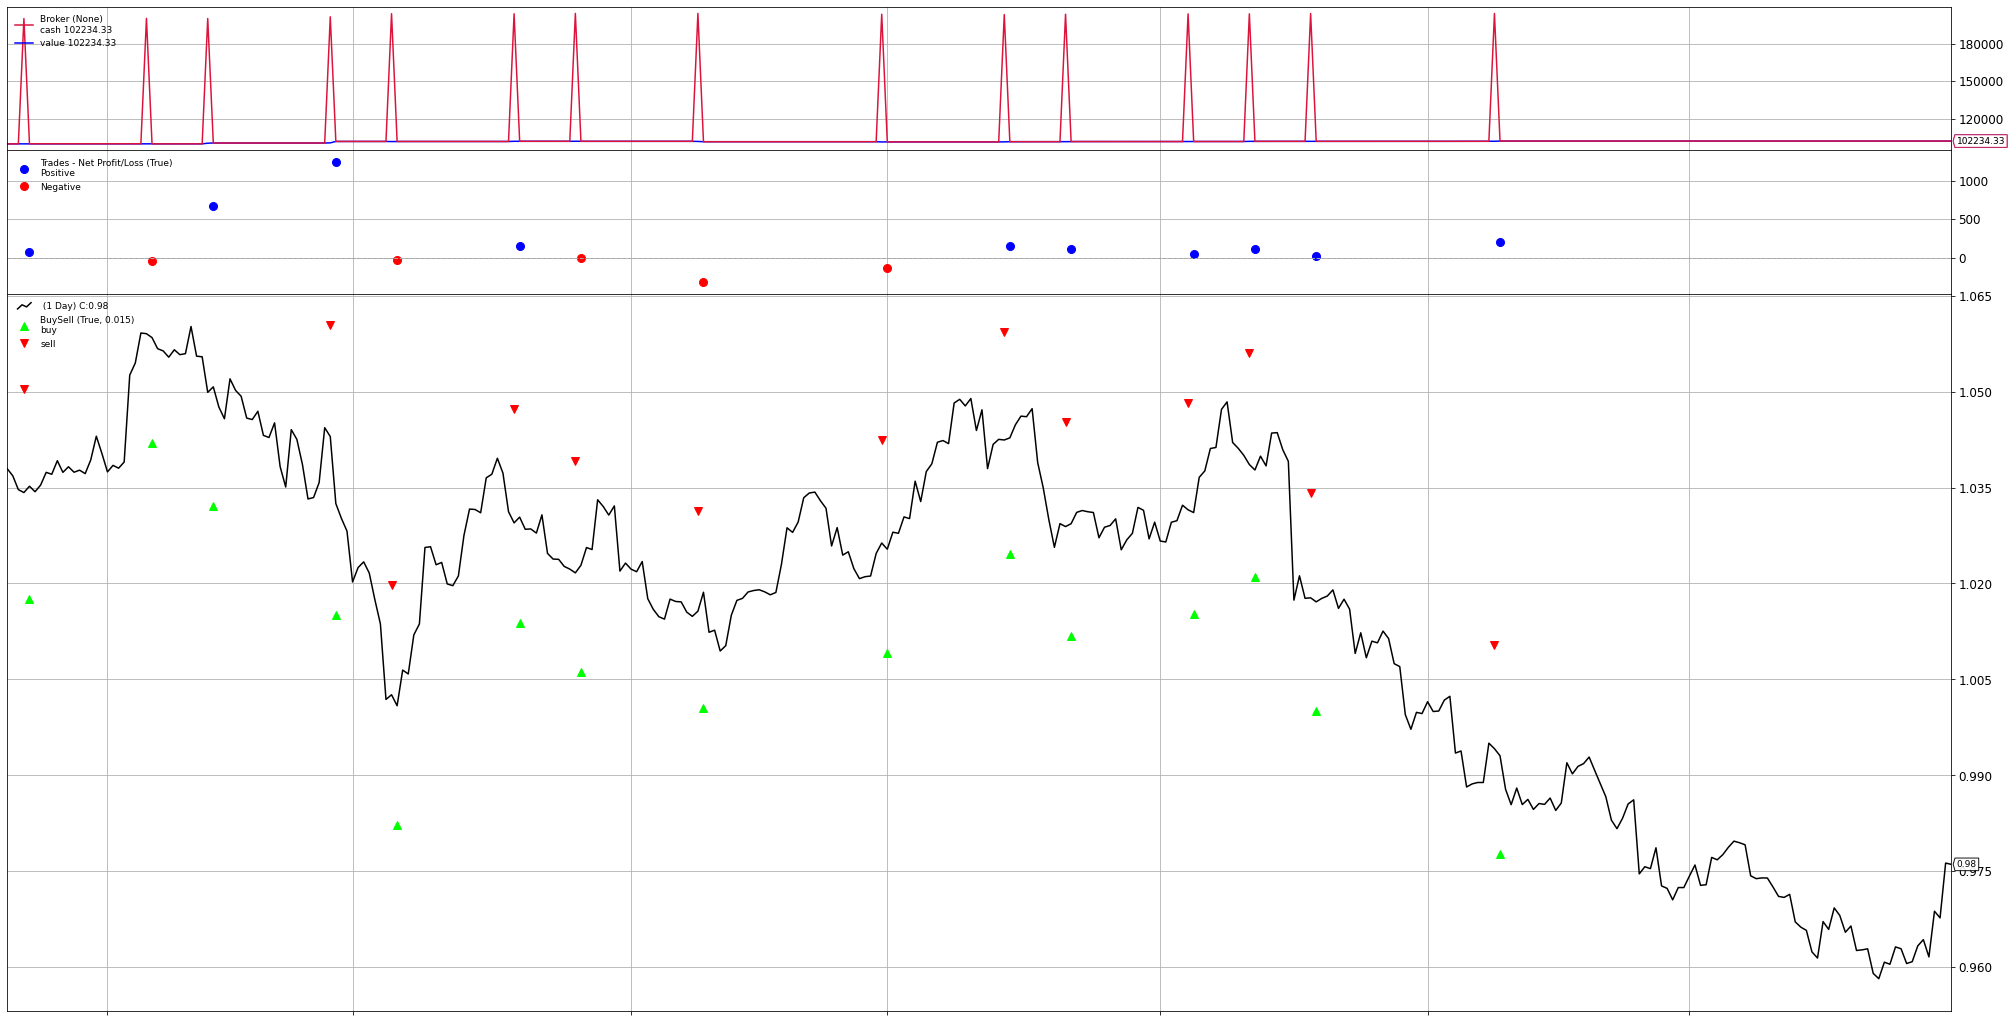

In [37]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams.update({'font.size': 12})
figure = cerebro.plot(volume=False, iplot = False)[0][0]
figure.savefig('example.png')

In [ ]:
# TO DO:
- why cash and value look odd?
- symbol size?